# 5. Logistic Classification

### Hypothesis

Sigmoid:

$$ H(x) = \sigma (Wx + b) = \frac{1}{1 + e^{-(Wx + b)}}$$

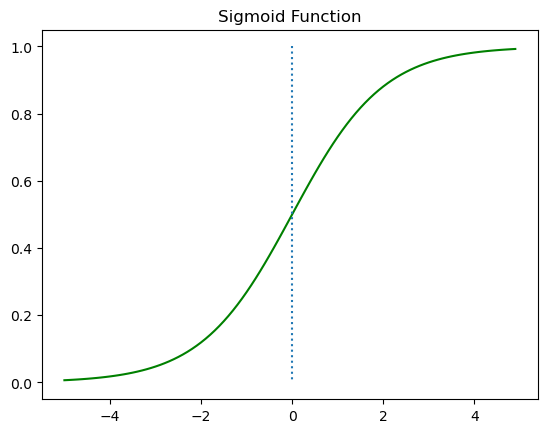

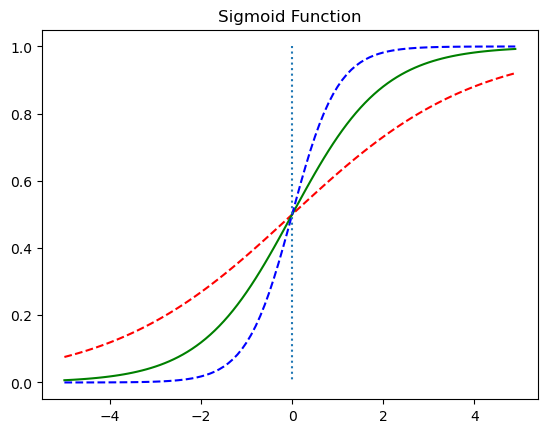

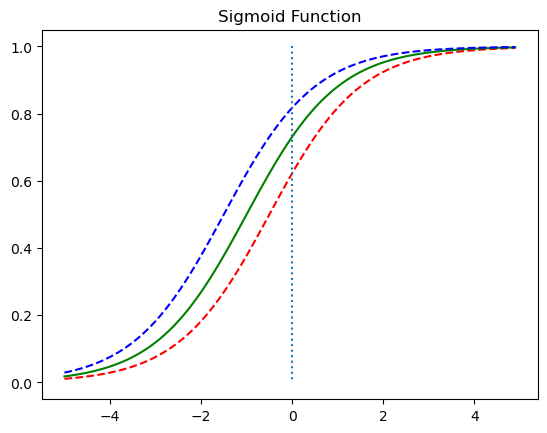

In [45]:
%matplotlib inline 

import numpy as np 
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)

plt.plot(x, y, 'g')
plt.plot([0,0],[1.0,0.0], ':') # 가운데 점선 추가
plt.title('Sigmoid Function')
plt.show()

# different W values
x = np.arange(-5.0, 5.0, 0.1)
y1 = sigmoid(0.5*x)
y2 = sigmoid(x)
y3 = sigmoid(2*x)

plt.plot(x, y1, 'r', linestyle='--') # W의 값이 0.5일때
plt.plot(x, y2, 'g') # W의 값이 1일때
plt.plot(x, y3, 'b', linestyle='--') # W의 값이 2일때
plt.plot([0,0],[1.0,0.0], ':') # 가운데 점선 추가
plt.title('Sigmoid Function')
plt.show()


# different b values
x = np.arange(-5.0, 5.0, 0.1)
y1 = sigmoid(x+0.5)
y2 = sigmoid(x+1)
y3 = sigmoid(x+1.5)

plt.plot(x, y1, 'r', linestyle='--') # x + 0.5
plt.plot(x, y2, 'g') # x + 1
plt.plot(x, y3, 'b', linestyle='--') # x + 1.5
plt.plot([0,0],[1.0,0.0], ':') # 가운데 점선 추가
plt.title('Sigmoid Function')
plt.show()

### Cost

$$ cost(W,b) = -\frac{1}{m} \sum y \log\left(H(x)\right) + (1-y) \left( \log(1-H(x) \right) $$


Here, we replace $H(x) = Wx + b$  with $H(x) = \sigma(Wx + b)$.

### Weight Update via Gradient Descent

$$ W := W - \alpha \frac{\partial}{\partial W} cost(W) $$

 - $\alpha$: Learning rate

## Imports

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
# For reproducibility
torch.manual_seed(1)

## Training Data

In [48]:
x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]

Consider the following classification problem: given the number of hours each student spent watching the lecture and working in the code lab, predict whether the student passed or failed a course. For example, the first (index 0) student watched the lecture for 1 hour and spent 2 hours in the lab session ([1, 2]), and ended up failing the course ([0]).

In [49]:
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

As always, we need these data to be in `torch.Tensor` format, so we convert them.

In [50]:
print(x_train.shape)
print(y_train.shape)

torch.Size([6, 2])
torch.Size([6, 1])


## Computing the Hypothesis

$$ H(X) = \frac{1}{1+e^{-(W^T X + b)}} $$

In [6]:
W = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [51]:
hypothesis = 1 / (1 + torch.exp(-(x_train.matmul(W) + b)))

In [52]:
print(hypothesis)
print(hypothesis.shape)

tensor([[5.4423e-05],
        [1.6844e-02],
        [2.0160e-02],
        [9.7644e-01],
        [9.9951e-01],
        [9.9994e-01]], grad_fn=<MulBackward0>)
torch.Size([6, 1])


Or, we could use `torch.sigmoid()` function! This resembles the sigmoid function:

In [54]:
hypothesis = torch.sigmoid(x_train.matmul(W) + b)

In [55]:
print(hypothesis)
print(hypothesis.shape)

tensor([[5.4423e-05],
        [1.6844e-02],
        [2.0160e-02],
        [9.7644e-01],
        [9.9951e-01],
        [9.9994e-01]], grad_fn=<SigmoidBackward0>)
torch.Size([6, 1])


## Computing the Cost Function (Low-level)

$$ cost(W) = -\frac{1}{m} \sum y \log\left(H(x)\right) + (1-y) \left( \log(1-H(x) \right) $$

We want to measure the difference between `hypothesis` and `y_train`.

In [56]:
print(hypothesis)
print(y_train)

tensor([[5.4423e-05],
        [1.6844e-02],
        [2.0160e-02],
        [9.7644e-01],
        [9.9951e-01],
        [9.9994e-01]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])


For one element, the loss can be computed as follows:

In [57]:
-(y_train[0] * torch.log(hypothesis[0]) + 
  (1 - y_train[0]) * torch.log(1 - hypothesis[0]))

tensor([5.4421e-05], grad_fn=<NegBackward0>)

To compute the losses for the entire batch, we can simply input the entire vector.

In [58]:
losses = -(y_train * torch.log(hypothesis) + 
           (1 - y_train) * torch.log(1 - hypothesis))
print(losses)

tensor([[5.4421e-05],
        [1.6988e-02],
        [2.0366e-02],
        [2.3840e-02],
        [4.9043e-04],
        [6.3779e-05]], grad_fn=<NegBackward0>)


Then, we just `.mean()` to take the mean of these individual losses.

In [59]:
cost = losses.mean()
print(cost)

tensor(0.0103, grad_fn=<MeanBackward0>)


## Computing the Cost Function with `F.binary_cross_entropy`

In reality, binary classification is used so often that PyTorch has a simple function called `F.binary_cross_entropy` implemented to lighten the burden.

In [60]:
F.binary_cross_entropy(hypothesis, y_train)

tensor(0.0103, grad_fn=<BinaryCrossEntropyBackward0>)

## Training with `F.binary_cross_entropy`

In [62]:
# initialization
W = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer
optimizer = optim.SGD([W, b], lr=1)

nb_epochs = 5000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    hypothesis = torch.sigmoid(x_train.matmul(W) + b) # or .mm or @
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    
    if epoch % 500 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/5000 Cost: 0.693147
Epoch  500/5000 Cost: 0.037261
Epoch 1000/5000 Cost: 0.019852
Epoch 1500/5000 Cost: 0.013562
Epoch 2000/5000 Cost: 0.010305
Epoch 2500/5000 Cost: 0.008311
Epoch 3000/5000 Cost: 0.006965
Epoch 3500/5000 Cost: 0.005994
Epoch 4000/5000 Cost: 0.005260
Epoch 4500/5000 Cost: 0.004687
Epoch 5000/5000 Cost: 0.004227


In [65]:
hypothesis = torch.sigmoid(x_train.matmul(W) + b)
print(hypothesis)

# If hypothesis > 0.5, then True. Otheriwse, False
prediction = hypothesis >= torch.FloatTensor([0.5])
print(prediction)

tensor([[5.8982e-06],
        [7.0134e-03],
        [8.2570e-03],
        [9.9012e-01],
        [9.9992e-01],
        [9.9999e-01]], grad_fn=<SigmoidBackward0>)
tensor([[False],
        [False],
        [False],
        [ True],
        [ True],
        [ True]])


## Logistic regression wth nn.Module

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)



In [67]:
x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

nn.Sequential()은 nn.Module 층을 차례로 쌓을 수 있음: nn.Sequential()은 $Wx + b$ 와 같은 수식과 sigmoid function 등과 같은 여러 함수들을 연결.



In [70]:
model = nn.Sequential(
   nn.Linear(2, 1), # input_dim = 2, output_dim = 1
   nn.Sigmoid() # 출력은 시그모이드 함수를 거친다
)

In [71]:
model(x_train)

tensor([[0.3600],
        [0.2872],
        [0.6801],
        [0.4389],
        [0.5216],
        [0.7473]], grad_fn=<SigmoidBackward0>)

In [73]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)

    # cost 계산
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5]) # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))

Epoch    0/1000 Cost: 0.019941 Accuracy 100.00%
Epoch  100/1000 Cost: 0.018239 Accuracy 100.00%
Epoch  200/1000 Cost: 0.016806 Accuracy 100.00%
Epoch  300/1000 Cost: 0.015583 Accuracy 100.00%
Epoch  400/1000 Cost: 0.014526 Accuracy 100.00%
Epoch  500/1000 Cost: 0.013604 Accuracy 100.00%
Epoch  600/1000 Cost: 0.012792 Accuracy 100.00%
Epoch  700/1000 Cost: 0.012072 Accuracy 100.00%
Epoch  800/1000 Cost: 0.011429 Accuracy 100.00%
Epoch  900/1000 Cost: 0.010851 Accuracy 100.00%
Epoch 1000/1000 Cost: 0.010329 Accuracy 100.00%


In [74]:
model(x_train)
print(list(model.parameters()))


[Parameter containing:
tensor([[3.8933, 1.8551]], requires_grad=True), Parameter containing:
tensor([-17.4164], requires_grad=True)]


## Using Class

In [43]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

클래스(class) 형태의 모델은 nn.Module 을 상속

__init__()에서 모델의 구조와 동적을 정의하는 생성자를 의미함. 객체가 생성될 때 자동으호 호출

super() 함수를 부르면 여기서 만든 클래스는 nn.Module 클래스의 속성들을 가지고 초기화. 

foward() 함수는 모델이 학습데이터를 입력받아서 forward 연산을 진행시키는 함수. model 객체를 데이터와 함께 호출하면 자동으로 실행

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))
    
model = BinaryClassifier()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = model(x_train)

    # cost 계산
    cost = F.binary_cross_entropy(hypothesis, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()


    if epoch % 100 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5]) 
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))

Epoch    0/1000 Cost: 0.539713 Accuracy 83.33%
Epoch  100/1000 Cost: 0.134272 Accuracy 100.00%
Epoch  200/1000 Cost: 0.080486 Accuracy 100.00%
Epoch  300/1000 Cost: 0.057820 Accuracy 100.00%
Epoch  400/1000 Cost: 0.045251 Accuracy 100.00%
Epoch  500/1000 Cost: 0.037228 Accuracy 100.00%
Epoch  600/1000 Cost: 0.031649 Accuracy 100.00%
Epoch  700/1000 Cost: 0.027538 Accuracy 100.00%
Epoch  800/1000 Cost: 0.024381 Accuracy 100.00%
Epoch  900/1000 Cost: 0.021877 Accuracy 100.00%
Epoch 1000/1000 Cost: 0.019843 Accuracy 100.00%
